# Variational Autoencoder with PyTorch vs PCA

Check how VAE is similar to a PCA but works in a non-linear way.

In [1]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [2]:
!kaggle datasets download -d brynja/wineuci

  0% 0.00/4.20k [00:00<?, ?B/s]
100% 4.20k/4.20k [00:00<00:00, 12.9MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/wineuci.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Variational autoencoder is different from autoencoder in a way such that it provides a statistic manner for describing the samples of the dataset in latent space. Therefore, in variational autoencoder, the encoder outputs a probability distribution in the bottleneck layer instead of a single output value.

 A variational autoencoder (VAE) provides a probabilistic manner for describing an observation in latent space. Thus, rather than building an encoder that outputs a single value to describe each latent state attribute, encoder describe a probability distribution for each latent attribute.

It has many applications such as data compression, synthetic data creation etc.

In [4]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn import preprocessing
from sklearn.decomposition import PCA



In [5]:
df = pd.read_csv("/content/Wine.csv",sep=',', header=None, names=['Wine', 'Alcohol','Malic.acid','Ash','Acl',
                                                    'Mg', 'Phenols', 'Flavanoids','Nonflavanoid.phenols',
                                                    'Proanth','Color.int','Hue', 'OD','Proline'])
df.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
def load_data(df):
  # replace nan with -99
  df = df.fillna(-99)
  df_base = df.iloc[:, 1:]
  print(f"df_base shape : {df_base.shape}")
  # get wine Label
  df_wine = df.iloc[:,0].values
  x = df_base.values.reshape(-1, df_base.shape[1]).astype('float32')
  print(f"x shape : {x.shape}")
  # stadardize values
  standardizer = preprocessing.StandardScaler()
  x = standardizer.fit_transform(x)
  return x, standardizer, df_wine


## PCA

In [7]:
x_pca, standardizer, df_wine = load_data(df)

df_base shape : (178, 13)
x shape : (178, 13)


In [8]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x_pca)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
finalDf = pd.concat([principalDf, pd.DataFrame(df_wine, columns = ['wine'])], axis = 1)
finalDf.head()

,principal component 1,principal component 2,principal component 3,wine
0,3.316750,-1.443462,-0.165739,1
1,2.209467,0.333392,-2.026458,1
2,2.516741,-1.031153,0.982821,1
3,3.757066,-2.756373,-0.176191,1
4,1.008908,-0.869830,2.026688,1


In [9]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

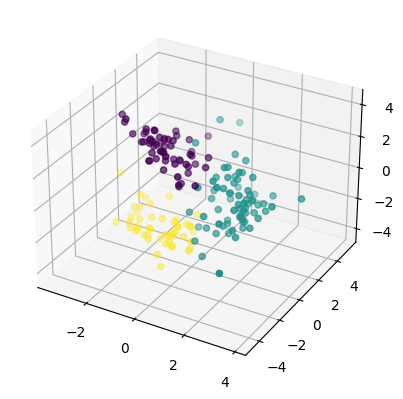

In [10]:
ax = plt.axes(projection='3d')


# Data for three-dimensional scattered points
winetype = finalDf.iloc[:,3].values
zdata = finalDf.iloc[:,0].values
xdata = finalDf.iloc[:,1].values
ydata = finalDf.iloc[:,2].values
ax.scatter3D(xdata, ydata, zdata, c=winetype);

# PyTorch Autoencoder

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Build Data Loader in PyTorch

In [26]:
from torch.utils.data import Dataset, DataLoader

class DataBuilder(Dataset):
  def __init__(self,df):
    self.x,self.standardizer,self.wine = load_data(df)
    self.x = torch.from_numpy(self.x).to(device)
    self.len = self.x.shape[0]

  def __getitem__(self,index):
    return self.x[index]

  def __len__(self):
    return self.len

data_set=DataBuilder(df)
trainloader=DataLoader(dataset=data_set,batch_size=1024)
type(trainloader.dataset.x)

df_base shape : (178, 13)
x shape : (178, 13)


torch.Tensor

In [27]:
data_set.x

tensor([[ 1.5186, -0.5622,  0.2321,  ...,  0.3622,  1.8479,  1.0130],
        [ 0.2463, -0.4994, -0.8280,  ...,  0.4061,  1.1134,  0.9652],
        [ 0.1969,  0.0212,  1.1093,  ...,  0.3183,  0.7886,  1.3951],
        ...,
        [ 0.3328,  1.7447, -0.3894,  ..., -1.6121, -1.4854,  0.2806],
        [ 0.2092,  0.2277,  0.0127,  ..., -1.5683, -1.4007,  0.2965],
        [ 1.3951,  1.5832,  1.3652,  ..., -1.5244, -1.4289, -0.5952]],
       device='cuda:0')

## Build model

The encode function computes the mean and log variance of the latent space, while the reparameterize function samples from the latent space using the reparameterization trick. The decode function reconstructs the input from the latent space. The forward function connects all these components together during the forward pass of the model.

In a VAE, you have a latent space that you want to sample from, typically represented by a Gaussian distribution with mean (mu) and log variance (logvar). Sampling directly from this distribution would not be differentiable, and therefore, you wouldn't be able to backpropagate gradients through the sampling process. The reparameterization trick solves this problem by decoupling the sampling operation from the parameters of the distribution.

In [28]:
class Autoencoder(nn.Module):
  def __init__(self,D_in,H1=50,H2=12,latent_dim=3):
    # Encoder
    super(Autoencoder,self).__init__()
    self.linear1=nn.Linear(D_in,H1)
    self.lin_bn1 = nn.BatchNorm1d(num_features=H1)
    self.linear2=nn.Linear(H1,H2)
    self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
    self.linear3=nn.Linear(H2,H2)
    self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
    # Latent vectors mu and sigma
    self.fc1 = nn.Linear(H2, latent_dim)
    self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
    self.fc21 = nn.Linear(latent_dim, latent_dim)
    self.fc22 = nn.Linear(latent_dim, latent_dim)
    # Sampling vector
    self.fc3 = nn.Linear(latent_dim, latent_dim)
    self.fc_bn3 = nn.BatchNorm1d(latent_dim)
    self.fc4 = nn.Linear(latent_dim, H2)
    self.fc_bn4 = nn.BatchNorm1d(H2)
    # Decoder
    self.linear4=nn.Linear(H2,H2)
    self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
    self.linear5=nn.Linear(H2,H1)
    self.lin_bn5 = nn.BatchNorm1d(num_features=H1)
    self.linear6=nn.Linear(H1,D_in)
    self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)

    self.relu = nn.ReLU()

  def encode(self,x):
    # Encoder forward pass
    lin1 = self.relu(self.lin_bn1(self.linear1(x)))
    lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
    lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

    fc1 = F.relu(self.bn1(self.fc1(lin3)))

    r1 = self.fc21(fc1) # Mean of the latent space
    r2 = self.fc22(fc1) # Log variance of the latent space

    return r1, r2

  def reparameterize(self, mu, logvar):
    # Sample from a latent space in a differentiable manner.

    # when model is in training mode,sample from the Gaussian distribution to introduce
    # randomness and encourage the VAE to learn a meaningful latent representation
    if self.training:
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)
    # during inferrence or evaluation mode we don't want to introduce randomness rather
    # assuming that the Gaussian distribution is collapsed to its mean.
    else:
        return mu

  def decode(self,z):
    # Decoder forward pass
    fc3 = self.relu(self.fc_bn3(self.fc3(z)))
    fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

    lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
    lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
    return self.lin_bn6(self.linear6(lin5)) # Reconstructed output

  def forward(self,x):
    # mu: The mean of the Gaussian distribution in the latent space.
    # logvar: The logarithm of the variance of the Gaussian distribution in the latent space.
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    # self.decode(z) # we don't need this
    return self.decode(z), mu, logvar

Custom loss function combines the MSE loss, which measures the reconstruction error, with the KLD loss, which regularizes the latent space, to train a variational autoencoder. The combined loss guides the model to learn both good reconstructions and meaningful latent representations.

In [29]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [30]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [33]:
D_in = data_set.x.shape[1]
H1 = 50 # hidden state 1
H2 = 12 # hidden state 2
model = Autoencoder(D_in, H1, H2).to(device)
model.apply(weights_init_uniform_rule)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = customLoss()

In [34]:
epochs = 1500
log_interval = 50
val_losses = []
train_losses = []

In [36]:
from tqdm import tqdm

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
#        if batch_idx % log_interval == 0:
#            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                epoch, batch_idx * len(data), len(trainloader.dataset),
#                       100. * batch_idx / len(trainloader),
#                       loss.item() / len(data)))
    if epoch % 200 == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))


for epoch in tqdm(range(1, epochs + 1)):
    train(epoch)

 14%|█▍        | 208/1500 [00:01<00:12, 106.65it/s]

====> Epoch: 200 Average loss: 9.0164


 28%|██▊       | 414/1500 [00:04<00:12, 88.52it/s]

====> Epoch: 400 Average loss: 8.8959


 41%|████▏     | 619/1500 [00:06<00:04, 190.70it/s]

====> Epoch: 600 Average loss: 8.5525


 55%|█████▍    | 821/1500 [00:07<00:03, 187.00it/s]

====> Epoch: 800 Average loss: 7.9249


 68%|██████▊   | 1021/1500 [00:08<00:02, 191.93it/s]

====> Epoch: 1000 Average loss: 7.5129


 82%|████████▏ | 1224/1500 [00:09<00:01, 185.39it/s]

====> Epoch: 1200 Average loss: 7.3120


 95%|█████████▌| 1426/1500 [00:10<00:00, 194.70it/s]

====> Epoch: 1400 Average loss: 7.3029


100%|██████████| 1500/1500 [00:10<00:00, 141.42it/s]


## evaluation

In [37]:
standardizer = trainloader.dataset.standardizer

In [38]:
model.eval()
test_loss = 0

with torch.no_grad():
    for i, data in enumerate(trainloader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)

In [45]:
# Assuming recon_batch[65] has shape (13, 1), and you need it as (1, 13)
recon_batch_reshaped = recon_batch[65].view(1, -1)
reconstructed_data = standardizer.inverse_transform(recon_batch_reshaped.cpu().numpy())
print(f"shape : {reconstructed_data.shape}")
print("="*80)
reconstructed_data

shape : (1, 13)


array([[1.2559414e+01, 2.1944227e+00, 2.3655705e+00, 1.9877771e+01,
        9.5443695e+01, 2.6220651e+00, 2.5871794e+00, 2.9502958e-01,
        1.8348809e+00, 3.4497259e+00, 1.0039504e+00, 3.0691662e+00,
        6.6214539e+02]], dtype=float32)

In [46]:
# Assuming data[65] has shape (13, 1), and you need it as (1, 13)
recon_batch_reshaped = data[65].view(1, -1)
reconstructed_data = standardizer.inverse_transform(recon_batch_reshaped.cpu().numpy())
print(f"shape : {reconstructed_data.shape}")
print("="*80)
reconstructed_data

shape : (1, 13)


array([[1.237e+01, 1.210e+00, 2.560e+00, 1.810e+01, 9.800e+01, 2.420e+00,
        2.650e+00, 3.700e-01, 2.080e+00, 4.600e+00, 1.190e+00, 2.300e+00,
        6.780e+02]], dtype=float32)

The recon_batch is the reconstructed data. So after putting the data through the encoder we compress the dimensions to 3 (embeddings). With these 3 representaions/embeddings of each row the decoder tries to convert it back to the original data. So basically, this recontructed row feeds itself from only three numbers.

# Get Embeddings

In [47]:
mu_output = []
logvar_output = []

with torch.no_grad():
    for i, (data) in enumerate(trainloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)


            mu_tensor = mu
            mu_output.append(mu_tensor)
            mu_result = torch.cat(mu_output, dim=0)  # Concatenate mu values along a dimension to obtain a single tensor

            logvar_tensor = logvar
            logvar_output.append(logvar_tensor)
            logvar_result = torch.cat(logvar_output, dim=0)

In [48]:
print(f"mu_result shape : {mu_result.shape}")
print("="*80)
mu_result[1:5,:]

mu_result shape : torch.Size([178, 3])


tensor([[ 0.6535, -0.6309, -0.0391],
        [ 0.5509, -0.8139, -0.0541],
        [ 1.0499, -1.1655,  0.0051],
        [ 0.1851, -0.3908, -0.0277]], device='cuda:0')

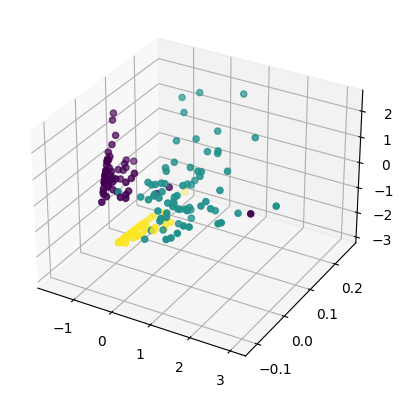

In [49]:
ax = plt.axes(projection='3d')


# Data for three-dimensional scattered points
winetype = data_set.wine
zdata = mu_result[:,0].cpu().numpy()
xdata = mu_result[:,1].cpu().numpy()
ydata = mu_result[:,2].cpu().numpy()
ax.scatter3D(xdata, ydata, zdata, c=winetype);

In [50]:
#